In [4]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [128]:
data = pd.read_csv('earnings_data.csv')
data_og = data

In [129]:
data = pd.get_dummies(data, drop_first=True)

In [73]:
data.head()

,gender,career,years_of_experience,salary
0,male,consulting,0,47000
1,male,consulting,0,48000
2,male,consulting,0,48500
3,male,consulting,0,50000
4,male,consulting,0,75000


In [53]:
data.tail()

,years_of_experience,salary,gender_male,career_se
2447,20,84332,0,1
2448,20,107653,0,1
2449,20,95629,0,1
2450,20,86987,0,1
2451,20,94793,0,1


In [130]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('salary', axis = 1),
                                                    np.log1p(data.salary.values),
                                                    test_size =.30,
                                                    random_state=12345)
dtrain = xgb.DMatrix(data = X_train, label=y_train)
dtest = xgb.DMatrix(data = X_test, label=y_test)
param = {'eta':0.1,
         'objective':'reg:linear'}
xgb_model = xgb.train(param, dtrain, num_boost_round=100)
X_test['y_hat_with_bias'] = np.exp(xgb_model.predict(dtest)) - 1

[09:14:48] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


In [54]:
X_test.tail()

,years_of_experience,gender_male,career_se,y_hat_with_bias
598,20,1,0,117048.812500
308,10,1,0,96890.875000
1232,0,1,1,57922.742188
178,5,1,0,71279.656250
1523,9,1,1,93071.265625


In [75]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [76]:
sns.set_theme(color_codes=True)
tips = data

In [77]:
tips.head()

,gender,career,years_of_experience,salary
0,male,consulting,0,47000
1,male,consulting,0,48000
2,male,consulting,0,48500
3,male,consulting,0,50000
4,male,consulting,0,75000


In [81]:
se_data = data[data['career']=='se']


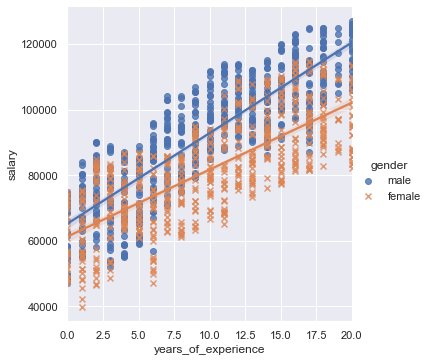

In [131]:
sns.lmplot(x="years_of_experience", y="salary", hue="gender",  data=se_data, markers=["o", "x"],);

In [133]:
import shap

explainer = shap.Explainer(xgb_model, X_test)
shap_values = explainer(X_test[:1523])

# visualize the first prediction's explanation
shap.plots.scatter(shap_values[:,'years_of_experience'], color=shap_values['gender'])
#shap.plots.scatter(shap_values[:,'y_hat_with_bias'], color=shap_values)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [134]:
feature_names = dtest.feature_names
interactions = xgb_model.predict(dtest, pred_interactions=True)
pd.DataFrame(interactions[0],
             index = feature_names + ['intercept'],
             columns= feature_names + ['intercept'])

,years_of_experience,gender_male,career_se,intercept
years_of_experience,0.249059,-0.012967,0.011549,0.000000
gender_male,-0.012967,-0.059626,0.006620,0.000000
career_se,0.011549,0.006620,-0.005303,0.000000
intercept,0.000000,0.000000,0.000000,11.336657


In [136]:
interactions

array([[[ 2.49059081e-01, -1.29670091e-02,  1.15489932e-02,
          0.00000000e+00],
        [-1.29669309e-02, -5.96262217e-02,  6.62012538e-03,
          0.00000000e+00],
        [ 1.15490779e-02,  6.62012771e-03, -5.30313328e-03,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.13366566e+01]],

       [[ 1.72735199e-01,  1.03313290e-03,  8.88295472e-05,
          0.00000000e+00],
        [ 1.03312731e-03,  5.95088303e-02, -2.52184761e-03,
          0.00000000e+00],
        [ 8.87811184e-05, -2.52184831e-03, -1.74909364e-03,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.13366566e+01]],

       [[ 2.17990786e-01,  1.55427866e-03,  3.03980289e-03,
          0.00000000e+00],
        [ 1.55428797e-03,  5.83946779e-02,  3.21616977e-03,
          0.00000000e+00],
        [ 3.03976238e-03,  3.21618095e-03,  1.17322756e-03,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+

In [113]:
bias_var = np.array('gender_male')
bias_idx = np.argwhere(np.isin(np.array(feature_names), bias_var))[0]
interactions[:, bias_idx, :] = 0
interactions[:, :, bias_idx] = 0
y_hat_no_bias = np.exp(interactions.sum(axis = 1).sum(axis = 1)) - 1

In [138]:
bias_idx.shape

(1,)

In [114]:
print(y_hat_no_bias)

[109480.51   99489.766 105018.375  72244.15   99822.79   84569.734
  70040.836  72639.11   99489.766 106268.67   70481.74   79874.71
  84963.516 106923.36   96219.04   67091.125  63111.21   99822.79
  96219.04   86454.81   94811.61   78616.03   92830.24   92855.92
 102644.62  105018.375  58180.02  105564.63  105872.64  102078.22
 104857.75   63574.242  67074.625  63210.6    78828.27  103839.414
  96118.24   72244.15  105409.61   62748.     98533.625 102078.22
  80745.15   62748.     93918.15   72244.15   72639.11  103839.414
  96118.24  103697.805  78828.27   62672.168  72337.984  70481.74
  58423.605  58423.605  70680.445  88788.695  78828.27   62748.
 106268.67   58180.02   92855.92   80768.875  95290.32   88788.695
  80745.38   62748.    105018.375  58423.605  97213.9    99558.58
  97213.9    98533.625  72858.56  102078.22   80067.74   93331.88
 109480.51   72639.11   80745.38   93918.15   72858.56  104857.75
  70229.79   72742.48   99489.766  72742.48   80745.15   97213.9
  84569.7

In [106]:
len(y_hat_no_bias)
y_train.head()

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [121]:
X_train.head()

,years_of_experience,gender_male,career_se
765,4,0,0
72,2,1,0
529,17,1,0
919,10,0,0
705,3,0,0


In [169]:
y_pred = xgb_model.predict(y_hat_no_bias, pred_interactions=True)

TypeError: ('Expecting data to be a DMatrix object, got: ', <class 'numpy.ndarray'>)

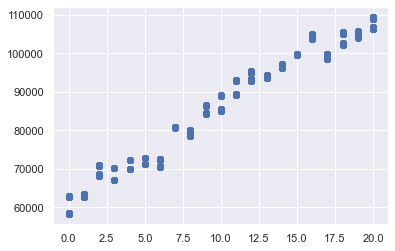

In [155]:
plt.scatter(X_test['years_of_experience'],y_hat_no_bias)

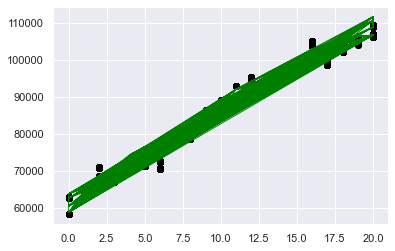

In [168]:
plt.scatter(X_test['years_of_experience'], y_hat_no_bias, color='black')
#plt.scatter(X_test_female, y_test_female,  color='red')
#plt.plot(X_test_male, y_pred_male, color='blue', linewidth=3)
plt.plot(X_test['years_of_experience'], y_pred, color='green', linewidth=1)

#plt.xticks(())
#plt.yticks(())

plt.show()

In [161]:
print(y_hat_no_bias.shape)
print(X_test['years_of_experience'].shape)

(736,)
(736,)


In [163]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
regr  = LinearRegression()
regr.fit(X_test['years_of_experience'], y_hat_no_bias)
y_pred   = regr.predict(y_hat_no_bias)

print("Male:")
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_hat_no_bias, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_hat_no_bias, y_pred))
print('Intercept: %.2f'
      % regr.intercept_)


ValueError: Expected 2D array, got 1D array instead:
array=[20 15 16  4 17  9  4  6 15 20  6  8 10 20 14  3  1 17 14  9 12  8 11 12
 18 16  0 18 19 18 16  1  3  1  8 16 14  4 19  1 17 18  7  1 13  4  6 16
 14 16  8  0  6  6  0  0  2 10  8  1 20  0 12  7 12 10  7  1 16  0 14 15
 14 17  5 18  8 12 20  6  7 13  5 16  3  5 15  5  7 14  9  2  6  8  3  7
  7 15 16  2 18 17 12  2 18 18  0 10  9 14  3  4  7 14  7  9 18 20 10 18
 13 18 11 12  4  4 10 11 14 13  7  7 10 16  4 20 11  3  2  6 13 17  0 16
  6 14 11  4 15 16 17 13 14 10 13  7 14  5  9  5  6 16  1 20  3  1 17 17
  2 15 13  9  4 17  8 16  9 18  4  0 12  2  1 17  9  3  3 15  9  3 15 18
 20  9 13 13 20  4  6 17  5 12 12  1 17  4 12 12 12 17 12 18 15  3  6  2
 10  3  4 17 15 15 10  8  0 15 20  4 12  0  8  2 10 15 18  5 10  3  0 12
  9 18  3 15  4 10  2  1  3  1 20  6  0 16  3  4  5 15 16  1 20 20 16 14
 20  3 11  7 13 18 15 12  0 20 15 14 14  7 12 19 20 16 15  2  7 13  0 16
  4  9  2  2 10  5 10  8  9  7 17  5  0  9 20  7  4  6 11  6 20  2 13 11
 16  0 11 13 20 16  9  1  7  8 16 12 14 18  5  3 17 10 11  3 13  8  6 20
 15 13 18 12 17  7  7  5  8  1 11  5 16 14 16  2  0 17 16 10 11  6 12  6
  5 15 15 14 17  9 14  6 18  7  4 20 20 20 12 19  7 10 10 16  3  0 18 17
  6  3 13  9 15 15  7 10  0 18  3  5 11  0  0 16 19  2 10 10 11 15  6  3
 18 17 20 11  0 11 20 13  4  5  8  0  0  5 16  9  4  3 18 17  3  4  1 14
  5  2 11 11 18 12 14 18 16  5 12 12  6 19  8 12 14 13  3 12 13  4 15 12
 16  7 14 20  6 12  2 17 16 16  6  2  4 15  4 14  6  5 14  5 18  4  2  4
 14 18 16  0  1  7 10 19 15  7  1  1 11 18  1  9 17  0  2  2  0 10  5  3
 20 13 16  2  5 12  1 12  8  4  4 16 16 18  6  2 18 11  9  3  5  3  4 20
 13 13 15 19 11  2  4 11  6  6  1 11 14 20 11  9  5  5  8  1  8 18  7  5
  4  0 14  3  0  8 14  8 17 13  6  2 17 13 12 11 10 10  3 11  1  4  8 20
 14 11  8 20  4 17 15  6 12  4 10 11  1 10  6  1  2  1  0 18  0 10 12  4
  0  4 16  9 11 10 13 16 16  0  0 11 13 15 10 11  3 19  3 16  1  6  9 20
 14  7 16 13 14 14  8 12 20 11  3  6 11 12  5 16  5 12 18 10 17  4  6  6
  3  4  3 15 18 19  3 10 20 17 18  0  3  8 20  2 12  9 19  4 18 18 17 17
 20 12  6 11  4 20 18 16  1 15 13  2  9  6  7 14  8 13  7  6 11 11 16  0
 19 12  0 11  7  8 10  1 14 13  3 11  2 12 17  5 13  7 19 10  7  2 20  2
  0  1  4 11 14  7  6 15 14 11 13 20 10  0  5  9].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

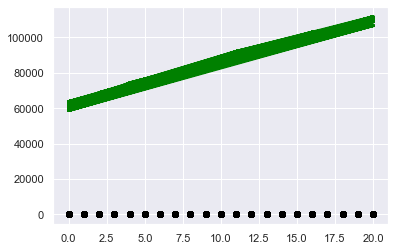

In [149]:
plt.scatter(X_test['years_of_experience'], y_test,  color='black')
plt.plot(X_test['years_of_experience'], y_pred, color='green', linewidth=3)

In [12]:
print(residuals_plot(xgb_model, X_train, y_train, X_test, y_test))

NameError: name 'residuals_plot' is not defined

In [ ]:
from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error

In [171]:
print(y_hat_no_bias.shape)

(736,)


In [172]:
y_hat_no_bias[0]

109480.51

In [175]:
new_df = []
X_test['y_hat_no_bias'] = y_hat_no_bias

In [176]:
X_test.head()

,years_of_experience,gender_male,career_se,y_hat_with_bias,y_hat_no_bias
1202,20,0,0,101841.929688,109480.507812
456,15,1,0,105275.984375,99489.765625
1720,16,1,1,112400.460938,105018.375000
131,4,1,0,69975.203125,72244.148438
542,17,1,0,103410.710938,99822.789062


In [177]:
new_df = X_test

In [178]:
new_df['difference'] = new_df["y_hat_with_bias"] - new_df["y_hat_no_bias"]

In [181]:
new_df['salary'] = y_test

In [182]:
new_df.head()

,years_of_experience,gender_male,career_se,y_hat_with_bias,y_hat_no_bias,difference,salary
1202,20,0,0,101841.929688,109480.507812,-7638.578125,11.393173
456,15,1,0,105275.984375,99489.765625,5786.218750,11.441730
1720,16,1,1,112400.460938,105018.375000,7382.085938,11.707521
131,4,1,0,69975.203125,72244.148438,-2268.945312,11.097425
542,17,1,0,103410.710938,99822.789062,3587.921875,11.718215


In [183]:
y_test[0]

11.3931729912432

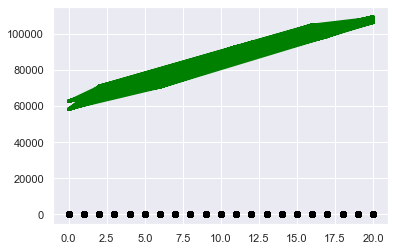

In [180]:
plt.scatter(X_test['years_of_experience'], y_test,  color='black')
plt.plot(X_test['years_of_experience'], X_test['y_hat_no_bias'], color='green', linewidth=3)

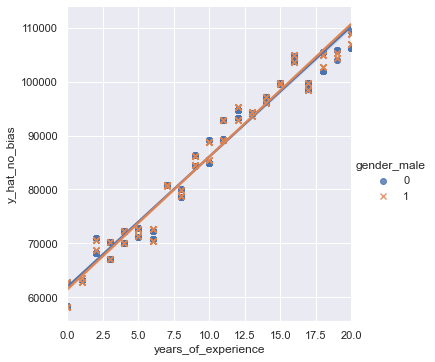

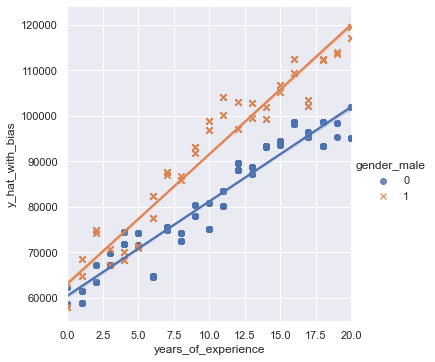

In [189]:
sns.lmplot(x="years_of_experience", y="y_hat_no_bias", hue="gender_male",  data=X_test, markers=["o", "x"],);
sns.lmplot(x="years_of_experience", y="y_hat_with_bias", hue="gender_male",  data=X_test, markers=["o", "x"],);

In [192]:
data_se = X_test[X_test['career_se']==1]
data_consulting = X_test[X_test['career_se']==0]

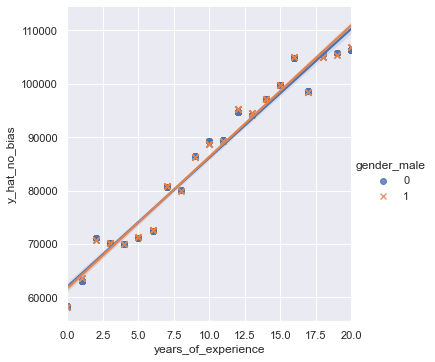

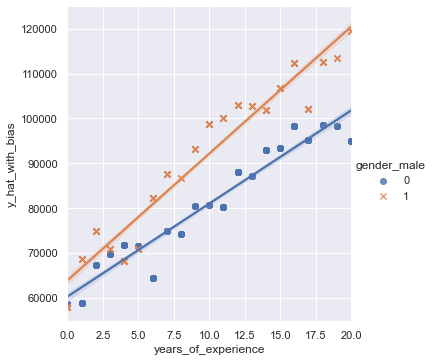

In [193]:
sns.lmplot(x="years_of_experience", y="y_hat_no_bias", hue="gender_male",  data=data_se, markers=["o", "x"],);
sns.lmplot(x="years_of_experience", y="y_hat_with_bias", hue="gender_male",  data=data_se, markers=["o", "x"],);